In [9]:
import sys
sys.path
sys.executable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn import preprocessing
from PIL import Image
from matplotlib import pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [10]:
import sys
sys.path
sys.executable
from sklearn.preprocessing import LabelEncoder

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [12]:
BASE_PATH ='/Users/anmolkhantaal/Desktop/OCD/dataset'

In [13]:
image=[]
labels=[]
for file in os.listdir(BASE_PATH):
    if file=='palm':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(c)
            labels.append('palm')
    if file=='ok':
        for c in os.listdir(os.path.join(BASE_PATH, file)):
            image.append(c)
            labels.append('ok')
            
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()

,Images,labels
0,img_CO_01_ok_0161_1_008_200.png,ok
1,img_CO_01_ok_0065_1_004_040.png,ok
2,img_CO_01_ok_0171_1_008_600.png,ok
3,img_CO_01_ok_0075_1_004_440.png,ok
4,img_CO_01_ok_0351_1_016_765.png,ok


In [14]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,img_CO_01_ok_0161_1_008_200.png,ok,0
1,img_CO_01_ok_0065_1_004_040.png,ok,0
2,img_CO_01_ok_0171_1_008_600.png,ok,0
3,img_CO_01_ok_0075_1_004_440.png,ok,0
4,img_CO_01_ok_0351_1_016_765.png,ok,0


In [15]:
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

In [16]:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
#train_indices is equivalent to list(tr.index)
#val_indices is equivalent to list(val.index)

In [17]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [19]:
class hg_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        label = label.type(torch.LongTensor)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [20]:
dataset = hg_Dataset(data,BASE_PATH,transform)


In [21]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [22]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

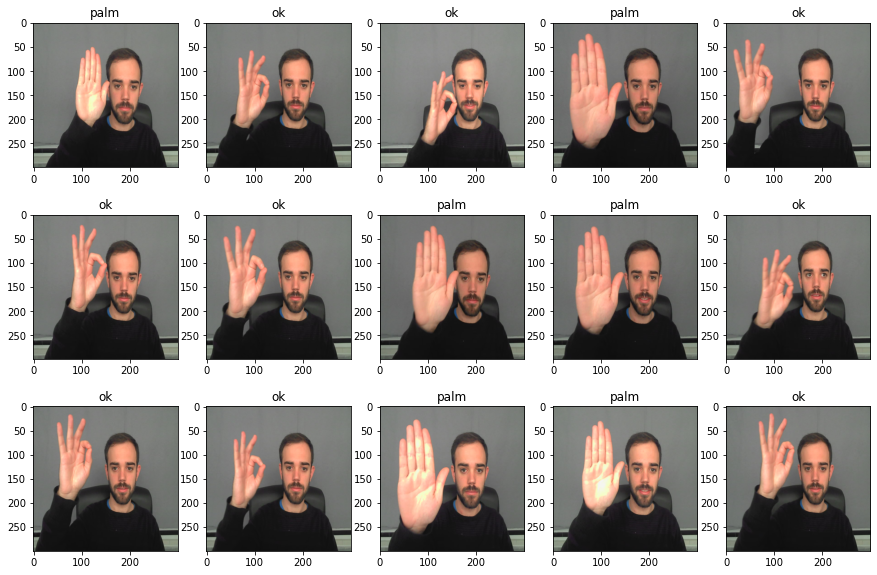

In [23]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'ok', 1: 'palm'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x


In [25]:
model = Net() # On CPU
#model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [27]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [28]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



/Users/anmolkhantaal/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/12], Step [0/5], Loss: 1.4292

train loss: 1.1478, train acc: 55.0654
validation loss: 1.3629, validation acc: 88.1226

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/5], Loss: 0.8073

train loss: 0.8964, train acc: 85.9477
validation loss: 1.3136, validation acc: 59.7701

Detected network improvement, saving current model
Epoch 3

Epoch [3/12], Step [0/5], Loss: 0.4720

train loss: 0.7280, train acc: 93.6275
validation loss: 1.2505, validation acc: 52.8736

Detected network improvement, saving current model
Epoch 4

Epoch [4/12], Step [0/5], Loss: 0.3010

train loss: 0.6053, train acc: 96.4052
validation loss: 1.1898, validation acc: 52.8736

Detected network improvement, saving current model
Epoch 5

Epoch [5/12], Step [0/5], Loss: 0.1805

train loss: 0.5137, train acc: 97.0588
validation loss: 1.1256, validation acc: 52.8736

Detected network improvement, saving current model
Epoch 6

Epoch [6/12], Step [0/5], Loss: 0.1182

train loss: 0.4

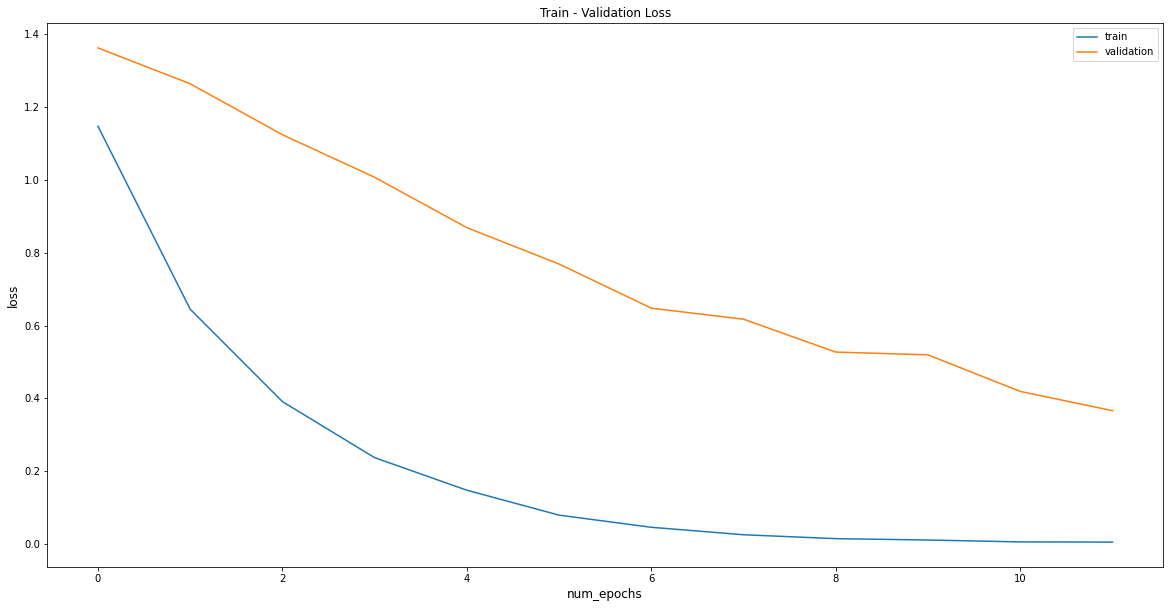

In [29]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

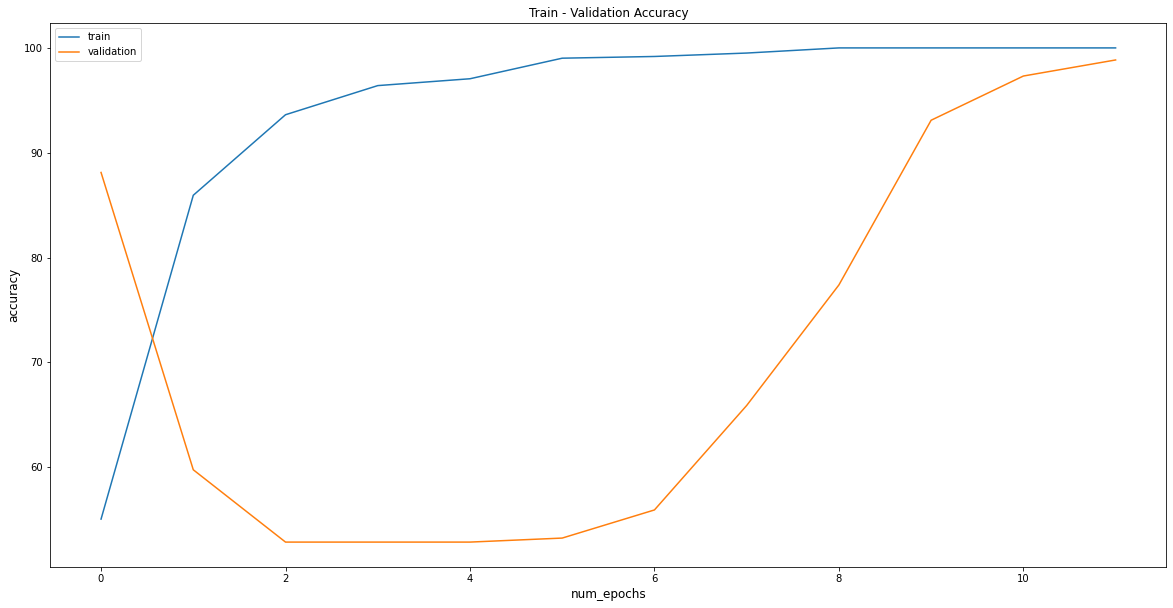

In [30]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [31]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

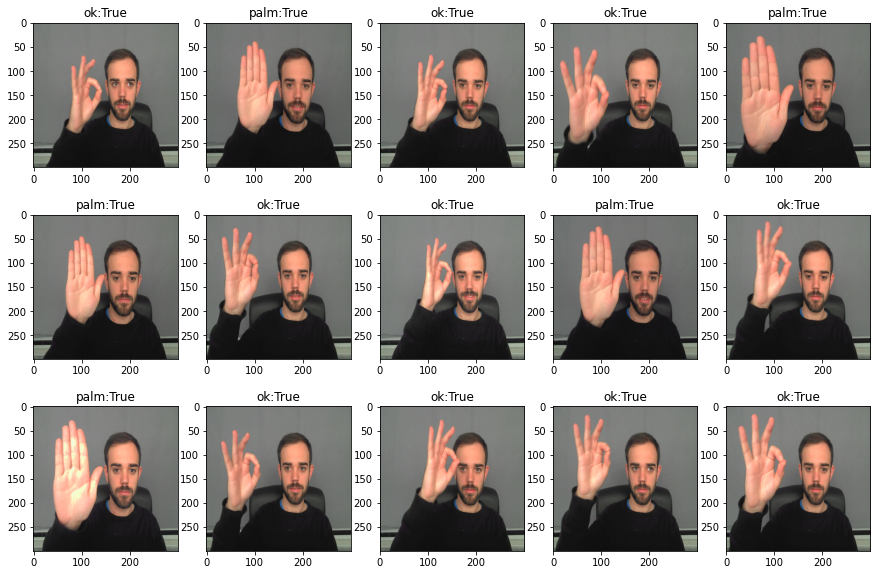

In [36]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
hg_types = {0: 'ok', 1: 'palm'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(hg_types[label.item()])+":" +str(k)) # add label

In [46]:
bp="state_dict_model.pt"

In [47]:
torch.save(hg_Dataset, bp)